
# 项目：巴西病人前往医院就诊数据探究

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

> 本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，包括 “预约日期 (ScheduledDay)”指患者具体预约就诊的日期；“街区 (Neighborhood) ”指医院所在位置；“福利保障 (Scholarship)”说明病人是否是巴西福利项目 Bolsa Família 的保障人群；请注意最后一列内容的编码：“No”表示病人已如约就诊，“Yes”说明病人未前往就诊。

> 探究问题如下：

> 有哪些重要因素能够帮助我们预测患者是否会按照其挂号预约前往医院就诊？

In [2]:
# 用这个框对你计划使用的所有数据包进行设置
# 导入语句。
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

<a id='wrangling'></a>
## 数据整理


### 常规属性

In [3]:
# 加载数据并打印前5行
no_show_appointments_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv', sep=',')
no_show_appointments_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# 查看数据行数与列数
no_show_appointments_df.shape

(110527, 14)

In [5]:
# 查看数据集类型，以及是否有缺失数据或错误数据的情况。
no_show_appointments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [6]:
# 查看是否有重复项
no_show_appointments_df.duplicated().sum()

0

In [7]:
# 查看是否有缺失值及缺失的具体数量
no_show_appointments_df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

根据数据集描述,PatientId、AppointmentID每行数据都是唯一值。Gender、Scholarship、Hipertension、Diabetes、Alcoholism、Handcap、No-show这些列均只有2种值。

In [8]:
# 查看ScheduledDay列的非空唯一值数量
no_show_appointments_df.ScheduledDay.nunique()

103549

In [9]:
# 查看AppointmentDay列的非空唯一值数量
no_show_appointments_df.AppointmentDay.nunique()

27

In [10]:
# 查看Age列的非空唯一值数量
no_show_appointments_df.Age.nunique()

104

In [11]:
# 查看Neighbourhood列的非空唯一值数量
no_show_appointments_df.Neighbourhood.nunique()

81

In [12]:
# 这些唯一值都是什么，以及每个的计数（ScheduledDay列的非空唯一值太多，不查看其值唯一值具体内容）
# 查看AppointmentDay的非空唯一值
no_show_appointments_df.AppointmentDay.unique()

array(['2016-04-29T00:00:00Z', '2016-05-03T00:00:00Z',
       '2016-05-10T00:00:00Z', '2016-05-17T00:00:00Z',
       '2016-05-24T00:00:00Z', '2016-05-31T00:00:00Z',
       '2016-05-02T00:00:00Z', '2016-05-30T00:00:00Z',
       '2016-05-16T00:00:00Z', '2016-05-04T00:00:00Z',
       '2016-05-19T00:00:00Z', '2016-05-12T00:00:00Z',
       '2016-05-06T00:00:00Z', '2016-05-20T00:00:00Z',
       '2016-05-05T00:00:00Z', '2016-05-13T00:00:00Z',
       '2016-05-09T00:00:00Z', '2016-05-25T00:00:00Z',
       '2016-05-11T00:00:00Z', '2016-05-18T00:00:00Z',
       '2016-05-14T00:00:00Z', '2016-06-02T00:00:00Z',
       '2016-06-03T00:00:00Z', '2016-06-06T00:00:00Z',
       '2016-06-07T00:00:00Z', '2016-06-01T00:00:00Z',
       '2016-06-08T00:00:00Z'], dtype=object)

In [13]:
# 查看Neighbourhood列的非空唯一值
no_show_appointments_df.Neighbourhood.unique()

array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

In [14]:
# 查看Age列的非空唯一值
no_show_appointments_df.Age.unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1])

In [20]:
# 查看异常值
df_outliers = no_show_appointments_df.query('Age == "-1"')
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 99832 to 99832
Data columns (total 14 columns):
PatientId         1 non-null float64
AppointmentID     1 non-null int64
Gender            1 non-null object
ScheduledDay      1 non-null object
AppointmentDay    1 non-null object
Age               1 non-null int64
Neighbourhood     1 non-null object
Scholarship       1 non-null int64
Hipertension      1 non-null int64
Diabetes          1 non-null int64
Alcoholism        1 non-null int64
Handcap           1 non-null int64
SMS_received      1 non-null int64
No-show           1 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 120.0+ bytes


> AppointmentDay有27个非空唯一值，其特征为数据只在日期上有变化，时间均为00:00:00

> Neighbourhood列非空唯一值的内容为医院所在地名称

> Age列为年龄，该列有一个异常值

### 数据整理

In [21]:
# 改变PatientId列值的类型
no_show_appointments_df['PatientId'] = no_show_appointments_df['PatientId'].astype("int64")

问题探究将使用以下数据列

> PatientId

> AppointmentID

> Gender

> Age

> SMS_received

> Scholarship

> 该病人已有疾病的数量（数据集无此列，需要添加）

> No-show

In [22]:
# 新加diseases_sum列，值为该病人已有疾病的数量
no_show_appointments_df.eval('diseases_sum = Hipertension + Diabetes + Alcoholism + Handcap' , inplace=True)

In [23]:
# 删除不需要的列
no_show_appointments_df.drop(['ScheduledDay', 'AppointmentDay', 'Neighbourhood'], axis=1, inplace=True)

In [24]:
# 列名均改为小写，'-'改为'_'
no_show_appointments_df.rename(columns=lambda x: x.strip().lower().replace("-", "_"), inplace=True)

In [26]:
# 删除异常值（只有一个异常值，删除该值对数据集的影响很小）
no_show_appointments_df = no_show_appointments_df.query('age != "-1"')

In [27]:
# 检验以上操作
no_show_appointments_df.head()

,patientid,appointmentid,gender,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,diseases_sum
0,29872499824296,5642903,F,62,0,1,0,0,0,0,No,1
1,558997776694438,5642503,M,56,0,0,0,0,0,0,No,0
2,4262962299951,5642549,F,62,0,0,0,0,0,0,No,0
3,867951213174,5642828,F,8,0,0,0,0,0,0,No,0
4,8841186448183,5642494,F,56,0,1,1,0,0,0,No,2


In [28]:
# 检验异常值是否被去除
no_show_appointments_df.age.unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99])

In [29]:
# 生成新的数据列，并保存为csv文件
no_show_appointments_df.to_csv('no_show_appointments_df.csv', index=False)

<a id='eda'></a>
## 探索性数据分析

> **提示**在你完成数据整理和清理之后，现在可以进行探索性数据分析了。你需要计算统计值，创建可视化图表，解决你在一开始的简介部分中提出的研究问题。我们推荐你采用系统化方法。一次只探索一个变量，然后探索变量之间的关系。

### 研究问题 ：有哪些重要因素能够帮助我们预测患者是否会按照其挂号预约前往医院就诊？

将探究以下数据与no_show之间的关系：
> 1.gender

> 2.age

> 3.sms_received

> 4.scholarship

> 5.diseases_sum

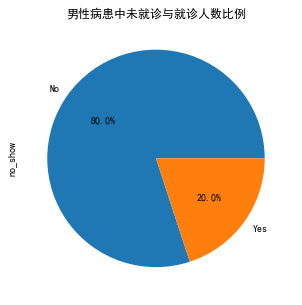

In [30]:
# 性别与就诊情况的关系
df_m = no_show_appointments_df.query('gender == "M"')
df_m['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="男性病患中未就诊与就诊人数比例")

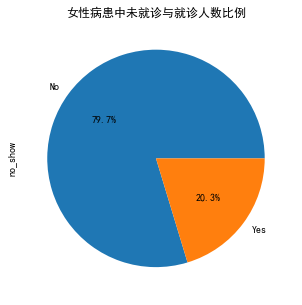

In [31]:
df_f = no_show_appointments_df.query('gender == "F"')
df_f['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="女性病患中未就诊与就诊人数比例")

> **性别与就诊情况的关系**：虽然数据集男性与女性样本总量不同，但是前往就诊人数与未就诊人数所占比例基本相同。

In [32]:
# 将数据集分已就诊与未就诊两类
no_df = no_show_appointments_df.query('no_show == "No"')
yes_df = no_show_appointments_df.query('no_show == "Yes"')

Text(0, 0.5, '就诊人数')

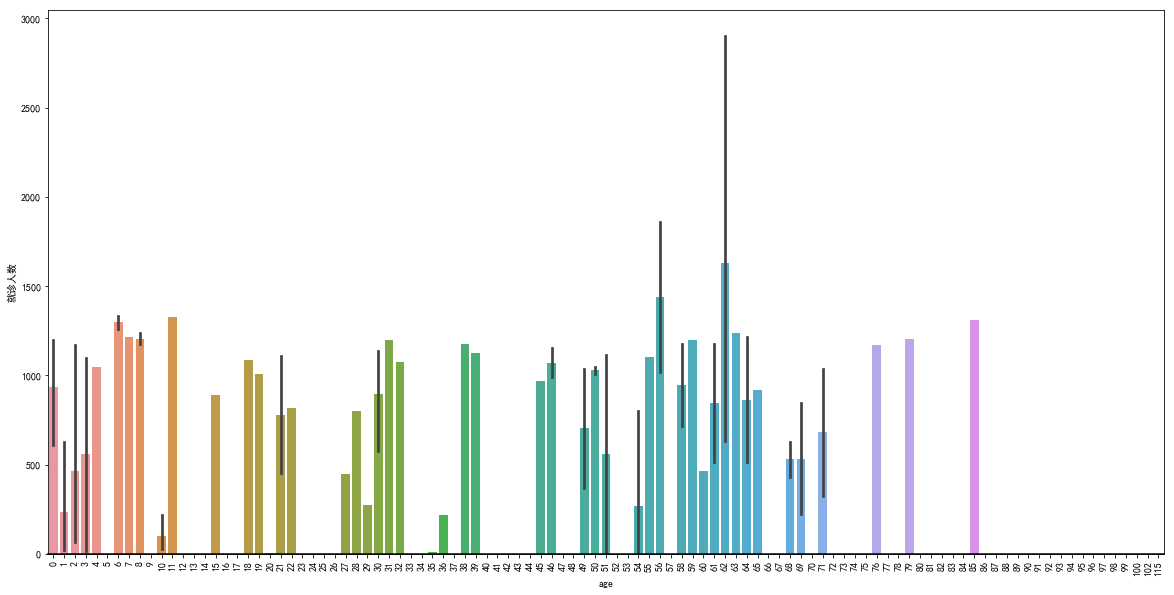

In [35]:
# 年龄与就诊情况的关系
# 就诊病人年龄的分布情况
no_df_age_count = no_df['age'].value_counts()
# 设置matplotlib格式
f, ax1 = plt.subplots(figsize=(20, 10), sharex=True)
sns.barplot(x = "age", y = no_df_age_count, data=no_df, ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
plt.xticks(rotation = 90)
ax1.set_ylabel("就诊人数")

Text(0, 0.5, '未就诊人数')

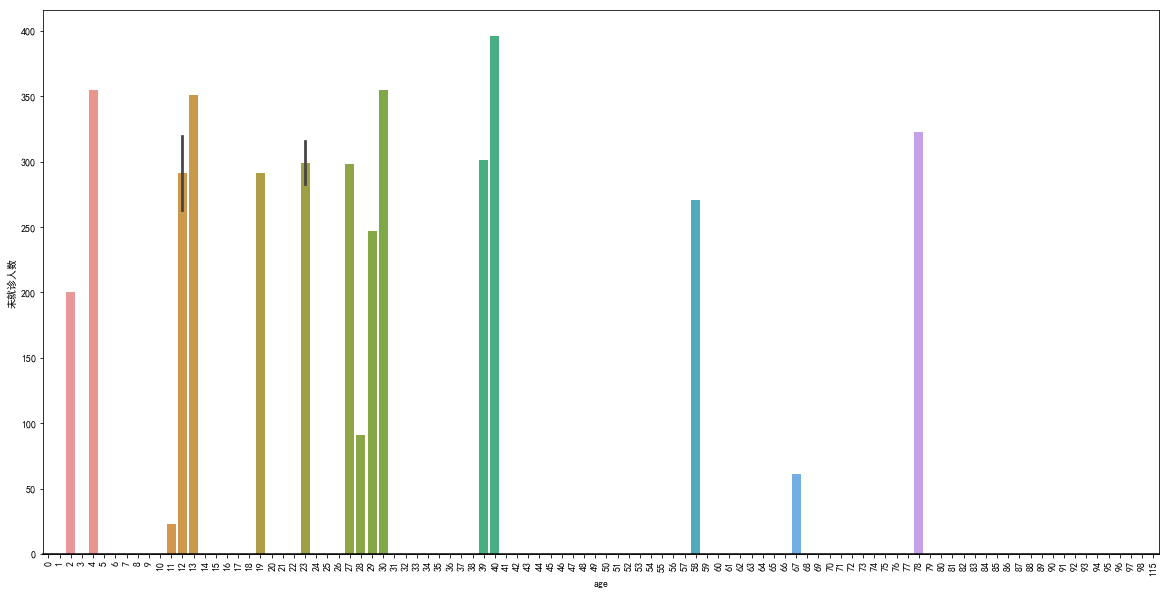

In [36]:
# 未就诊病人年龄的分布情况
yes_df_age_count = yes_df['age'].value_counts()
# 设置matplotlib格式
f, ax2 = plt.subplots(figsize=(20, 10), sharex=True)
sns.barplot(x = "age", y = yes_df_age_count, data=yes_df,ax=ax2)
ax2.axhline(0, color="k", clip_on=False)
plt.xticks(rotation = 90)
ax2.set_ylabel("未就诊人数")

> **年龄与就诊情况的关系**：年龄小于40岁的病人未就诊的情况较多。

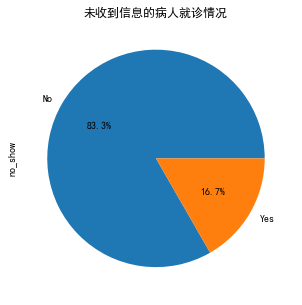

In [37]:
# 给病人发送信息与就诊情况的关系
# 未收到信息的病人中，病人的就诊情况
df_sms_received_0 = no_show_appointments_df.query('sms_received == "0"')
df_sms_received_0['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="未收到信息的病人就诊情况")

未收到信息的病人中，83.3%的人选择了就诊，16.7%的人未去就诊。

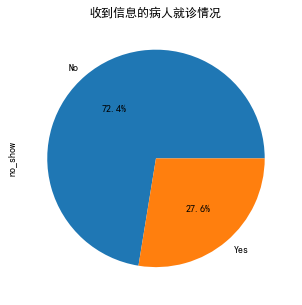

In [38]:
# 收到信息的病人中，病人的就诊情况
df_sms_received_1 = no_show_appointments_df.query('sms_received == "1"')
df_sms_received_1['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="收到信息的病人就诊情况")

收到信息的病人中，72.4%的人选择了就诊，27.6%的人未去就诊。
> **给病人发送信息与就诊情况的关系**：医院向患者发送信息的目的是提醒其按照约定时间就诊，但实际上收到信息再去就诊的患者比例反而比未收到信息去就诊的患者比例减少了10.9%。

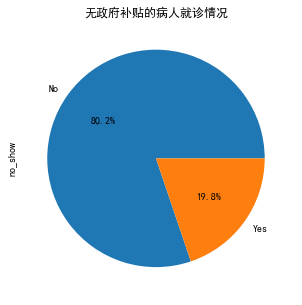

In [39]:
# 政府补助与就诊情况的关系
# 无政府补贴的病人中，病人的就诊情况
df_scholarship_0 = no_show_appointments_df.query('scholarship == "0"')
df_scholarship_0['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="无政府补贴的病人就诊情况")

无政府补贴的病人中，80.2%的人选择了就诊，19.8%的人未去就诊。

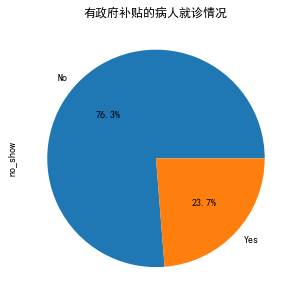

In [40]:
# 有政府补贴的病人中，病人的就诊情况
df_scholarship_1 = no_show_appointments_df.query('scholarship == "1"')
df_scholarship_1['no_show'].value_counts().plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="有政府补贴的病人就诊情况")

有政府补贴的病人中，76.3%的人选择了就诊，23.7%的人未去就诊。
> **政府补贴与就诊情况的关系**：有政府补贴也未能改善病人积极就医的态度，有政府补贴并去就诊的患者反而比没有政府补贴就诊的患者少了3.9%。

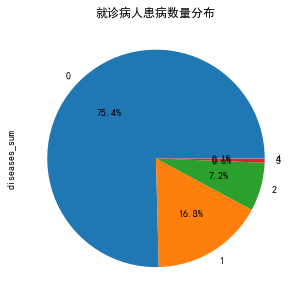

In [41]:
# 病人患病与就诊情况的关系
# 就诊病人患病的分布情况
no_df_diseases_sum_count = no_df['diseases_sum'].value_counts()
no_df_diseases_sum_count.plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="就诊病人患病数量分布")

就诊病人中，75.4%在预约时无病史，24.6%有病史。

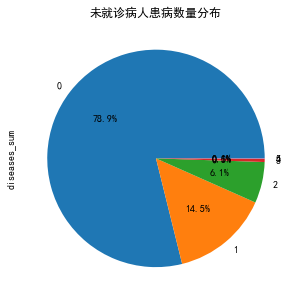

In [42]:
# 未就诊病人患病的分布情况
yes_df_diseases_sum_count = yes_df['diseases_sum'].value_counts()
yes_df_diseases_sum_count.plot(kind = 'pie', figsize = (5, 5), autopct='%1.1f%%', title="未就诊病人患病数量分布")

未就诊病人中，78.9%在预约时无病史，21.1%有病史。
> **病人患病与就诊情况的关系**：病人有病史是促进其就诊的一个因素，就诊的病人中24.6%的人有病史，未就诊的病人中21.1%的人有病史。

<a id='conclusions'></a>
## 结论

#### 根据可视化数据，我认为以下因素无法预测患者是否会按照其挂号预约前往医院就诊

> **性别**：虽然数据集男性与女性样本总量不同，但是前往就诊人数与未就诊人数所占比例基本相同。

> **给病人发送信息**：医院向患者发送信息的目的是提醒其按照约定时间就诊，但实际上收到信息再去就诊的患者比例反而比未收到信息去就诊的患者比例减少了10.9%。

> **政府补贴**：有政府补贴也未能改善病人积极就医的态度，有政府补贴并去就诊的患者反而比没有政府补贴就诊的患者少了3.9%。

#### 我认为以下因素能够帮助我们预测患者是否会按照其挂号预约前往医院就诊

> **年龄**：年龄大于40岁的病人未就诊的情况较少。

> **病人患病**：病人有病史是促进其就诊的一个因素，就诊的病人中24.6%的人有病史，未就诊的病人中21.1%的人有病史。

#### 本次数据探索的局限性

> 未探索就诊时间、预定时间、医院所在地，这三个特征值与问题之间的关系。

> 数据采用巴西预约挂号的就诊信息，只分析了一个国家的数据信息，不一定适用于其他国家。

> 年龄数据中只有一个异常值，删除该行数据对数据整体影响很小。

如需将报告导出到工作区，你可以运行下面的代码框。如果正确，会返回代码 0，工作区目录下会生成 .html 文件（单击左上角的 jupyter 图标）。也可以通过 **文件** > **下载为** 子菜单下载 html 报告，然后手动上传到工作区目录。完成之后，可以单击右下角的“提交项目”，来提交你的项目。恭喜你！

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

1